In [1]:
require(cowplot)
require(data.table)
require(ggplot2)
require(ggpubr)
require(pbapply)
pboptions(type="timer")

Loading required package: cowplot

Loading required package: data.table

Loading required package: ggplot2

Loading required package: ggpubr


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend


Loading required package: pbapply



In [2]:
nthreads=10
x_breaks = c(0, .01, .02, .03, .05, .07, .1, .2, .3, .5, .7, 1, 2, 3, 5, 7, 10, 20, 30, 50)

# Read spot data

In [3]:
thresholds = c(seq(0, .1, by=.01), seq(.2, 1, by=.1), seq(2, 50))
dw__root = "../data/single_FoV_different_thresholds/data/dw/"
raw_root = "../data/single_FoV_different_thresholds/data/raw/"

In [4]:
dw__data = rbindlist(pblapply(thresholds, function(thr) {
    d = fread(file.path(dw__root, sprintf("new_decoded_human_cortex_threshold_%05.2f_with_QC_metrics_type_of_unassigned.csv.gz", thr)))
    d$thr = thr
    d$image_type = "dw"
    return(d)
}, cl=nthreads))

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=05s  


In [5]:
raw_data = rbindlist(pblapply(thresholds, function(thr) {
    d = fread(file.path(raw_root, sprintf("new_decoded_human_cortex_before_deconvolution_threshold_%05.2f_with_QC_metrics_type_of_unassigned.csv.gz", thr)))
    d$thr = thr
    d$image_type = "raw"
    return(d)
}, cl=nthreads))

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=04s  


In [6]:
ddata = rbindlist(list(dw__data, raw_data))
ddata[, V1 := NULL]
ddata[, target_assigned := "unassigned"]
ddata['nan' != target, target_assigned := "assigned"]

In [7]:
colnames(ddata)

[1] "intensity"         "z"                 "y"                
 [4] "x"                 "radius"            "spot_id"          
 [7] "z_min"             "z_max"             "y_min"            
[10] "y_max"             "x_min"             "x_max"            
[13] "features"          "xc"                "yc"               
[16] "zc"                "target"            "distance"         
[19] "passes_thresholds" "FOV"               "QC_score"         
[22] "thr"               "image_type"        "target_assigned"

In [8]:
gene_counts = dcast(ddata["assigned" == target_assigned, .N, by=c("image_type", "target", "thr")],
                    target+thr~image_type, value.var="N")[order(dw, decreasing=T)]
colnames(gene_counts)

[1] "target" "thr"    "dw"     "raw"

# Visualize selected transcripts and compare between DW and RAW
Using a threshold of 2

In [9]:
pdata = ddata[target %in% c("FTH1", "SPARCL1", "ENC1", "SLC1A2", "CHN1", "CALM2") & thr==2]
head(pdata)
colnames(pdata)

intensity,z,y,x,radius,spot_id,z_min,z_max,y_min,y_max,⋯,yc,zc,target,distance,passes_thresholds,FOV,QC_score,thr,image_type,target_assigned
<dbl>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<chr>,<dbl>,<lgl>,<chr>,<dbl>,<dbl>,<chr>,<chr>
0.0028985124,0,499,450,2,4,0,1,498,500,⋯,81.25000,0,SPARCL1,0.2649681,TRUE,fov_000,0.5965618,2,dw,assigned
0.0090966122,0,499,224,5,5,0,1,495,500,⋯,81.25000,0,CHN1,0.3121750,TRUE,fov_000,0.4527587,2,dw,assigned
0.0021124284,0,499,146,3,8,0,1,497,500,⋯,81.25000,0,FTH1,0.1003793,TRUE,fov_000,0.7710983,2,dw,assigned
0.0009659652,0,496,220,2,10,0,1,495,498,⋯,80.76152,0,SPARCL1,0.1873796,TRUE,fov_000,0.5583532,2,dw,assigned
0.0057582282,0,494,152,2,14,0,1,493,496,⋯,80.43587,0,CHN1,0.1552498,TRUE,fov_000,0.7285791,2,dw,assigned
0.0017248141,0,491,467,2,17,0,1,490,493,⋯,79.94739,0,CHN1,0.3741780,TRUE,fov_000,0.4347573,2,dw,assigned


[1] "intensity"         "z"                 "y"                
 [4] "x"                 "radius"            "spot_id"          
 [7] "z_min"             "z_max"             "y_min"            
[10] "y_max"             "x_min"             "x_max"            
[13] "features"          "xc"                "yc"               
[16] "zc"                "target"            "distance"         
[19] "passes_thresholds" "FOV"               "QC_score"         
[22] "thr"               "image_type"        "target_assigned"

In [10]:
dcast(pdata[, .N, by=c("target", "image_type")], target~image_type, value.var="N")

target,dw,raw
<chr>,<int>,<int>
CALM2,634,401
CHN1,793,383
ENC1,954,684
FTH1,2159,1484
SLC1A2,854,509
SPARCL1,1748,1173


In [11]:
dcast(pdata[, .N, by=c("target", "image_type", "FOV")], FOV~target+image_type, value.var="N")

FOV,CALM2_dw,CALM2_raw,CHN1_dw,CHN1_raw,ENC1_dw,ENC1_raw,FTH1_dw,FTH1_raw,SLC1A2_dw,SLC1A2_raw,SPARCL1_dw,SPARCL1_raw
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
fov_000,29,17,42,23,27,26,106,80,43,23,72,45
fov_001,56,34,57,27,45,38,133,100,56,30,87,64
fov_002,24,15,43,23,32,26,115,83,96,50,85,61
fov_003,48,27,48,19,66,48,131,89,122,52,220,140
fov_004,31,14,23,11,24,19,117,81,65,43,73,48
fov_005,51,27,86,36,150,85,185,122,26,16,145,91
fov_006,39,25,70,34,71,57,145,94,87,61,178,126
fov_007,79,57,57,29,118,74,145,103,39,26,118,84
fov_008,30,20,39,24,52,39,143,104,49,33,91,65


In [12]:
pdata[, FOV_id := as.numeric(gsub("fov_", "", FOV))]

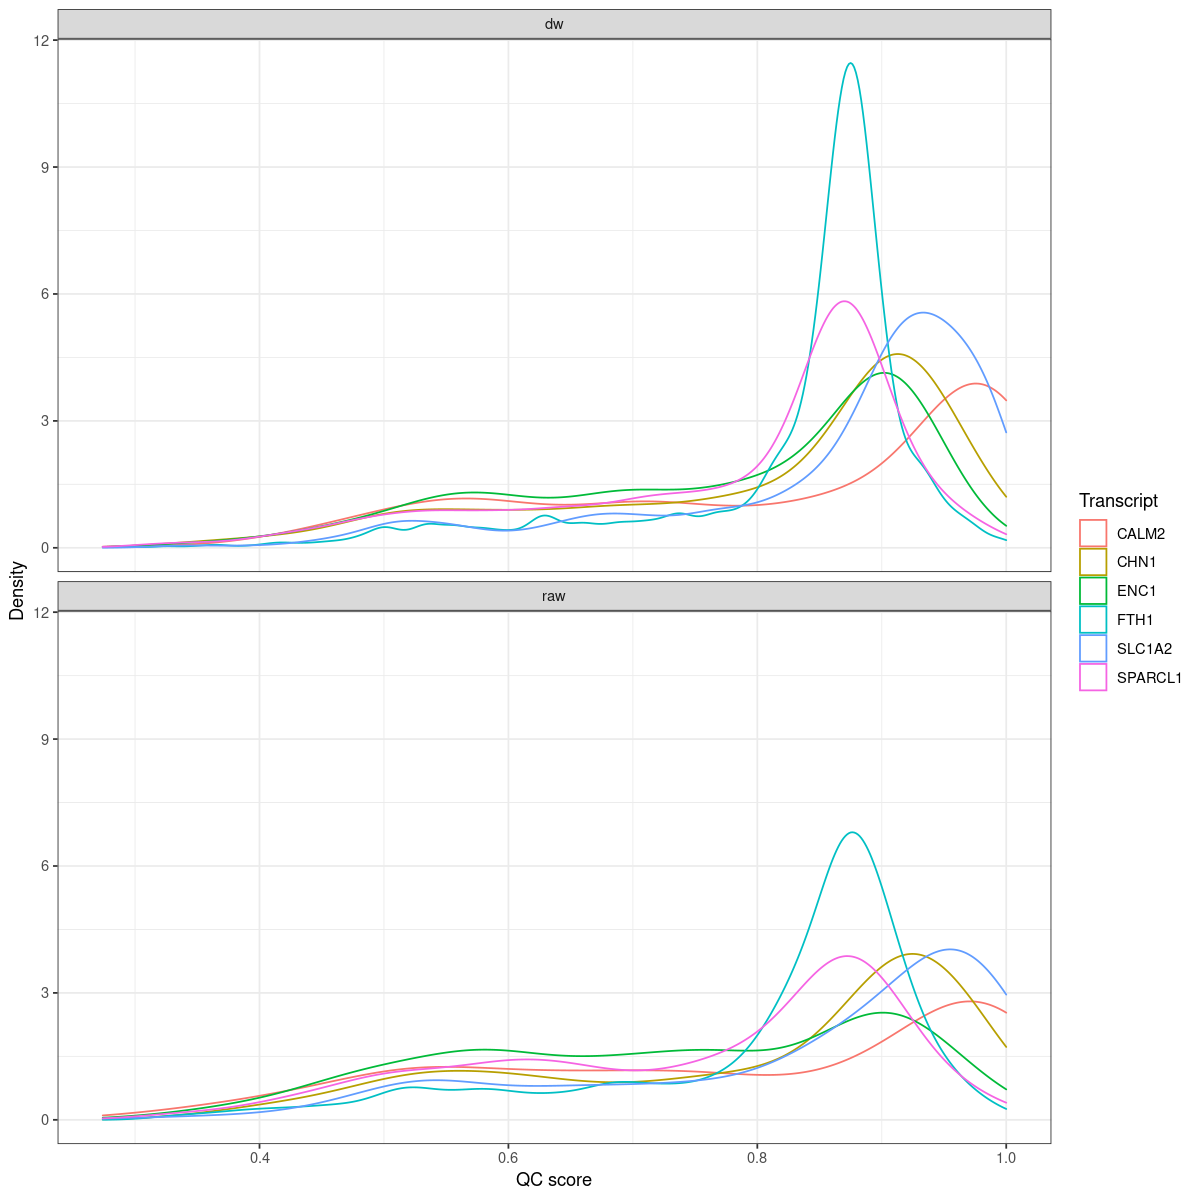

In [13]:
options(repr.plot.width=10, repr.plot.height=10)
ggplot(pdata[, .(QC_score, target, image_type)], aes(x=QC_score, color=target)) +
    geom_density() + facet_wrap(~image_type, nrow=2) +
    theme_bw() + labs(x="QC score", y="Density", color="Transcript")

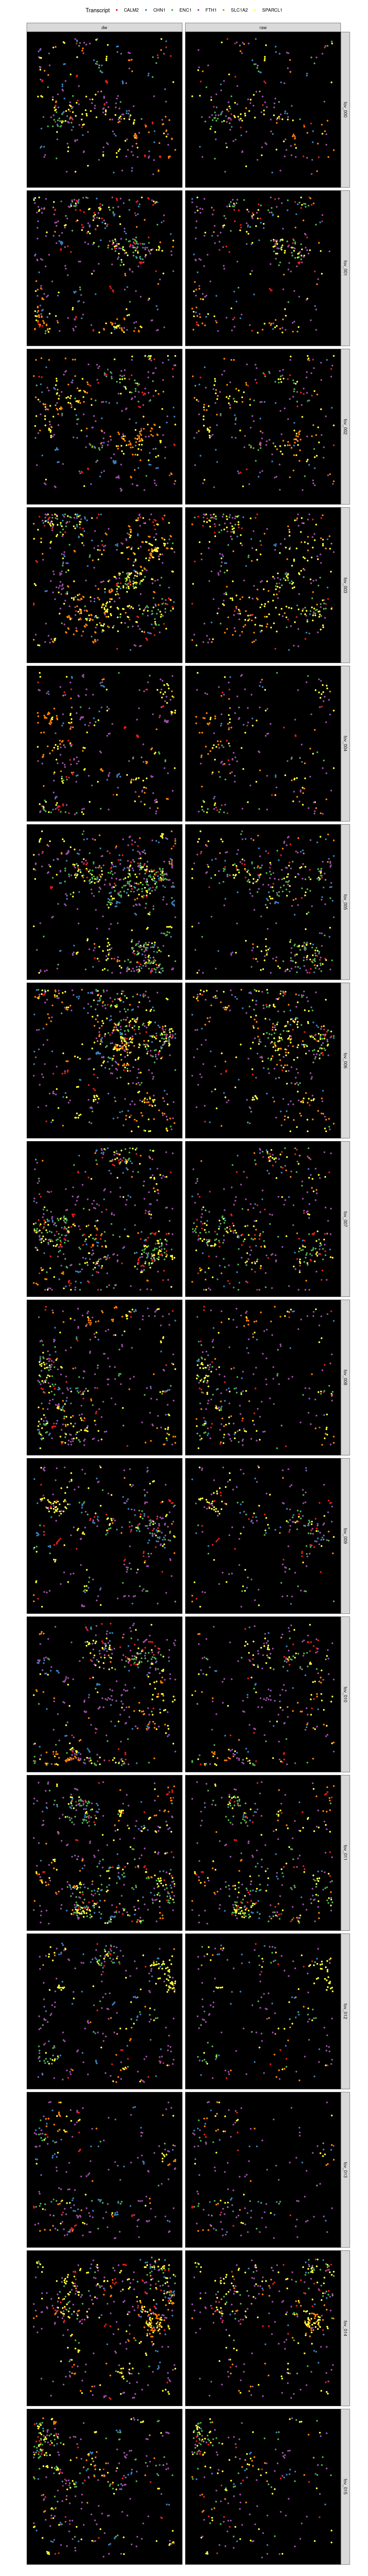

In [14]:
options(repr.plot.width=10, repr.plot.height=70)
p = ggplot(pdata[, .(x, y, target, FOV, image_type)],
        aes(x=x, y=y, color=target)) + geom_point(size=1) +
    facet_grid(~FOV~image_type) +
    theme_bw() + theme(
        legend.position="top",
        panel.grid.major=element_blank(), panel.grid.minor=element_blank(),
        panel.background=element_rect(fill="black"),
        axis.ticks.x=element_blank(), axis.ticks.y=element_blank(),
        axis.text.x=element_blank(), axis.text.y=element_blank()
    ) + guides(color=guide_legend(nrow=1)) +
    labs(x="", y="", color="Transcript") +
    coord_fixed() + scale_color_brewer(palette="Set1")
print(p)